In [25]:
from os import listdir
from os.path import isfile, join
from datetime import datetime
from collections import defaultdict
import bz2
import json
import pprint
from tqdm import tqdm
from multiprocessing import Process, Queue
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np

In [2]:
path = "/mnt/erebor1/Daten/ABI2/crawls/dreddit/comments_2020/"

lower_bound = datetime(2020, 5, 25)
upper_bound = datetime(2020, 6, 20)
keywords = ["george floyd", "dcblackout", "dc blackout", "black lives matter", "blm"]

def filter_name(name):
    global lower_bound, upper_bound
    date_str = name.split(".")[0]
    date = datetime.strptime(date_str, "comments-%Y-%m-%d_%H:%M:%S")
    return lower_bound < date < upper_bound

files = [path + f for f in listdir(path) if isfile(join(path, f)) and filter_name(f)]

In [3]:
for file_path in files:
    with bz2.open(file_path, "rt") as file:
        for line in file:
            post = json.loads(line)
            p = pprint.PrettyPrinter()
            p.pprint(post)
            break
        break

{'_fetched': True,
 '_replies': [],
 '_submission': None,
 'all_awardings': [],
 'approved_at_utc': None,
 'approved_by': None,
 'archived': False,
 'associated_award': None,
 'author': 'dmv_dictator',
 'author_flair_background_color': None,
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_template_id': None,
 'author_flair_text': None,
 'author_flair_text_color': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_3y39skuw',
 'author_patreon_flair': False,
 'author_premium': False,
 'awarders': [],
 'banned_at_utc': None,
 'banned_by': None,
 'body': "You know what, you may be very right about the regions. I didn't "
         "think about that. I'm pretty sure that I'm north of you and our area "
         'is opening up right now. I really appreciate finding that out.I also '
         "appreciate  fi doing out, though, that what we're being told is far "
         'from universal. Par for the course 😉',
 'body_html': '<div class="md"><p>You know wha

In [4]:
def get_relevant_subreddits(k_max=5):

    def run(_queue_batches, _queue_results):
        global keywords

        _sr_counts = defaultdict(int)

        while True:
            file_path = _queue_batches.get()

            if file_path is None:
                break

            with bz2.open(file_path, "rt") as file:
                for line in file:
                    post = json.loads(line)

                    # post about topic?
                    title = post.get("link_title").lower()
                    if any(list(map(lambda n: n in title, keywords))):
                        _sr_counts[post.get("subreddit")] += 1

        _queue_results.put(_sr_counts)
        _queue_results.put(None)
        # end run()    

        
    # create workers
    n_cores = 100
    q_batches = Queue(2*n_cores)
    q_results = Queue(2*n_cores)

    workers = [Process(target=run, args=(q_batches, q_results)) for _ in range(n_cores)]

    for w in workers:
        w.start()

    # put work batches
    for file_path in files:
        q_batches.put(file_path)

    for _ in range(n_cores):
        q_batches.put(None)

    # collect results
    sr_counts = defaultdict(int)
    
    remaining_nones = n_cores

    while remaining_nones > 0:
        next_counts = q_results.get()

        if next_counts is None:
            remaining_nones -= 1
            continue
        else:
            for k, v in next_counts.items():
                sr_counts[k] += v

    return sorted([(k, v) for k, v in sr_counts.items()], reverse=True, key=lambda n: n[1])[:k_max]

In [5]:
relevant_subreddits = get_relevant_subreddits(k_max=10)
relevant_subreddits

[('news', 43744),
 ('politics', 28680),
 ('PublicFreakout', 27355),
 ('pics', 20582),
 ('AskReddit', 12290),
 ('chicago', 8465),
 ('worldnews', 6715),
 ('conspiracy', 5754),
 ('Conservative', 5040),
 ('unpopularopinion', 4707)]

In [6]:
subreddits = [x[0] for x in relevant_subreddits]
subreddits

['news',
 'politics',
 'PublicFreakout',
 'pics',
 'AskReddit',
 'chicago',
 'worldnews',
 'conspiracy',
 'Conservative',
 'unpopularopinion']

In [7]:
def get_infection_timelines():

    def run(_queue_batches, _queue_results):
        global keywords, subreddits

        _timeline_infected = defaultdict(int)
        _timeline_total = defaultdict(int)
        _unique_infected = defaultdict(set)
        _unique_total = defaultdict(set)

        while True:
            file_path = _queue_batches.get()

            if file_path is None:
                break


            with bz2.open(file_path, "rt") as file:
                for line in file:
                    post = json.loads(line)

                    # filter on relevant subreddits
                    if not post.get("subreddit") in subreddits:
                        continue

                    ts = int(post.get("created_utc"))
                    ts = ts - ts % (60 * 60)  # runde auf volle stunde
                    ts = datetime.fromtimestamp(ts)
                    key = datetime.strftime(ts, "%Y-%m-%d_%H:00")
                    user = post.get("author_fullname")

                    # post about topic?
                    title = post.get("link_title").lower()
                    if any(list(map(lambda n: n in title, keywords))):
                        _unique_infected[key].add(user)
                        _timeline_infected[key] += 1
                    _timeline_total[key] += 1
                    _unique_total[key].add(user)


        _queue_results.put((_timeline_infected, _timeline_total, _unique_infected, _unique_total))
        _queue_results.put((None, None, None, None))
        # end run()    

    # create workers
    n_cores = 100
    q_batches = Queue(2*n_cores)
    q_results = Queue(2*n_cores)

    workers = [Process(target=run, args=(q_batches, q_results)) for _ in range(n_cores)]

    for w in workers:
        w.start()

    # put work batches
    for file_path in files:
        q_batches.put(file_path)

    for _ in range(n_cores):
        q_batches.put(None)

    # collect results
    timeline_infected_posts = defaultdict(int)
    timeline_total_posts = defaultdict(int)
    timeline_infected_users = defaultdict(set)
    timeline_total_users = defaultdict(set)

    remaining_nones = n_cores

    while remaining_nones > 0:
        next_infected, next_total, next_unique_user, next_unique_total = q_results.get()

        if next_infected is None:
            remaining_nones -= 1
            continue
        else:
            for k, v in next_infected.items():
                timeline_infected_posts[k] += v

            for k, v in next_total.items():
                timeline_total_posts[k] += v
                
            for k, v in next_unique_user.items():
                timeline_infected_users[k] = timeline_infected_users[k].union(v)
            
            for k, v in next_unique_total.items():
                timeline_total_users[k] = timeline_total_users[k].union(v)
               
    """
    Post-Processing of Time Series
    """
    
    # Time Series Ticks
    x_ticks = sorted(timeline_total_posts.keys())
    
    # Time Series about Posts
    timeline_infected_posts = [timeline_infected_posts[tick] for tick in x_ticks]
    timeline_total_posts = [timeline_total_posts[tick] for tick in x_ticks]
    
    # Cumulative Time Series about Unique Users
    tmp = []
    total_infected = set()
    for tick in x_ticks:
        total_infected = total_infected.union(timeline_infected_users[tick])
        tmp.append(len(total_infected))
    timeline_infected_cumulative = tmp
    del tmp, total_infected
    
    
    tmp = []
    total_infected = set()
    for tick in x_ticks:
        total_infected = total_infected.union(timeline_total_users[tick])
        tmp.append(len(total_infected))
    timeline_total_users = tmp
    del tmp, total_infected
    
    # Non-Cumulative Time Series about Unique Users
    timeline_infected = []
    for tick in x_ticks:
        timeline_infected.append(len(timeline_infected_users[tick]))
    
    # Approximate number of Infected Users with a Recovery Time of $time_infected$ (in h)
    time_infected = 48
    for i in range(len(x_ticks))[::-1]:
        infected_users = timeline_infected_users[x_ticks[i]]
        for j in range(i + 1, min(i + time_infected, len(x_ticks))):
            timeline_infected_users[x_ticks[j]] = timeline_infected_users[x_ticks[j]].union(infected_users)
        
    timeline_simultaneously_infected = []
    for tick in x_ticks:
        timeline_simultaneously_infected.append(len(timeline_infected_users[tick]))
    

    return x_ticks, timeline_infected_posts, timeline_total_posts, timeline_total_users, timeline_infected, timeline_infected_cumulative, timeline_simultaneously_infected


In [8]:
x_ticks, timeline_infected_posts, timeline_total_posts, timeline_total_users, timeline_infected, timeline_infected_cumulative, timeline_simultaneously_infected = get_infection_timelines()


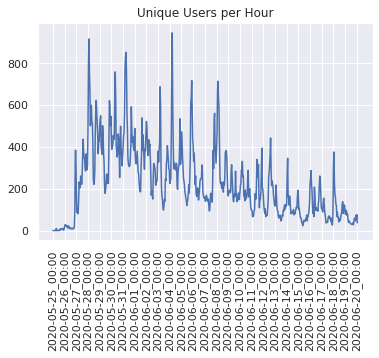

In [9]:
x = range(len(x_ticks))
plt.plot(x, timeline_infected, label="New Infected Users")
plt.title("Unique Users per Hour")
tick_interval = 24
plt.xticks(x[::tick_interval], x_ticks[::tick_interval], rotation=90);
plt.savefig("time_series_infected.pdf", bbox_inches='tight')

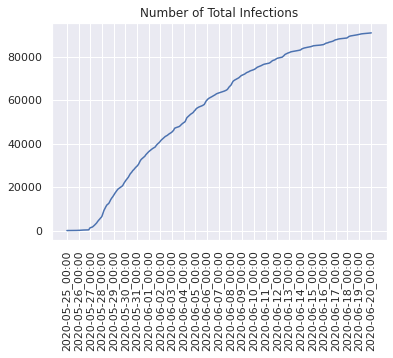

In [10]:
# Plot Infected Users Time Series
plt.plot(x, timeline_infected_cumulative, label="Infected Users")

# plt.legend()
plt.title("Number of Total Infections")
plt.xticks(x[::tick_interval], x_ticks[::tick_interval], rotation=90);
plt.savefig("time_series_total_infections.pdf", bbox_inches='tight')
plt.show()

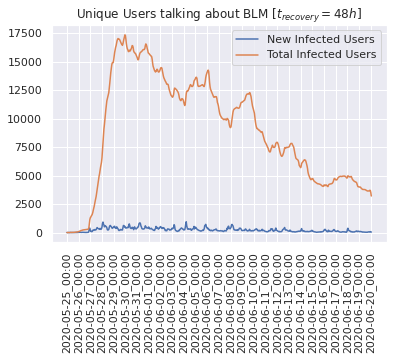

In [11]:
x = range(len(x_ticks))
plt.title("Unique Users talking about BLM [$t_{recovery}=48h}$]")
plt.plot(x, timeline_infected, label="New Infected Users")
plt.plot(x, timeline_simultaneously_infected, label="Total Infected Users")
plt.legend()
tick_interval = 24
plt.xticks(x[::tick_interval], x_ticks[::tick_interval], rotation=90);
plt.savefig("time_series_simultaneously_infected.pdf", bbox_inches='tight')
plt.show()

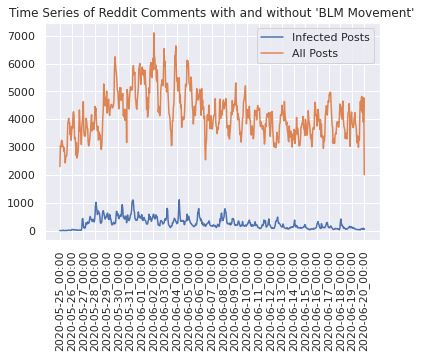

In [12]:
# Plot Comment Time Series
x = range(len(x_ticks))
plt.plot(x, timeline_infected_posts, label="Infected Posts")
plt.plot(x, timeline_total_posts, label="All Posts")

plt.legend()
plt.title("Time Series of Reddit Comments with and without 'BLM Movement'")
tick_interval = 24
plt.xticks(x[::tick_interval], x_ticks[::tick_interval], rotation=90);
plt.savefig("time_series_comments.pdf", bbox_inches='tight')
plt.show()

In [13]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

[0.00666465 0.00622513]


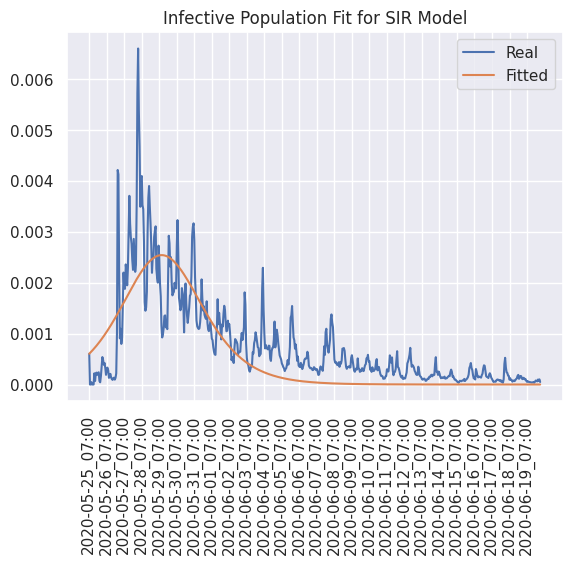

In [77]:
# shift time series
offset = np.where(np.asarray(timeline_infected) > 0)[0][0]

ydata = np.asarray(timeline_infected[offset:]) / timeline_total_users[offset:]

xdata = range(len(ydata))

def sir_model(y, xdata, beta, gamma):
    S = -beta * y[0] * y[1] / N
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

def fit_odeint(x, beta , gamma):
    return odeint(sir_model, (S0, I0, R0), xdata, args=(beta, gamma))[:,1]

N = 1.0
I0 = ydata[0]
S0 = N - I0
R0 = 0.0

popt, pcov = curve_fit(fit_odeint, xdata, ydata)
print(np.sqrt(np.diag(pcov)))  # standard deviation of errors on all parameters
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, label="Real")
plt.plot(xdata, fitted, label="Fitted")
plt.legend()
plt.title("Infective Population Fit for SIR Model")
plt.xticks(xdata[::tick_interval], x_ticks[offset::tick_interval], rotation=90);
plt.savefig("infective_population_fit_sir.pdf", bbox_inches='tight')

In [74]:
# Beta, Gamma
beta, gamma = popt
popt

array([0.38767593, 0.36356878])

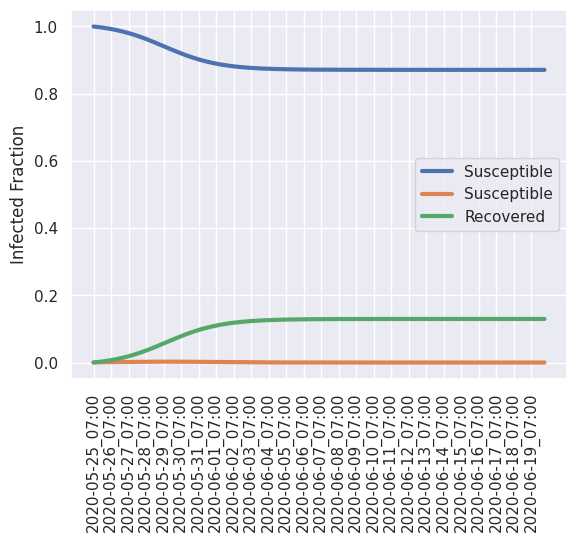

In [76]:
# Reconstruct Time Series
integral = odeint(sir_model, (S0, I0, R0), xdata, args=(*popt,))
s, i, r = integral.T

plt.plot(xdata, s, lw=3, label="Susceptible")
plt.plot(xdata, i, lw=3, label="Susceptible")
plt.plot(xdata, r, lw=3, label="Recovered")
plt.grid(True)
plt.legend()
plt.ylabel("Infected Fraction")
plt.xticks(xdata[::tick_interval], x_ticks[offset::tick_interval], rotation=90);
plt.savefig("sir_timeline.pdf", bbox_inches='tight')

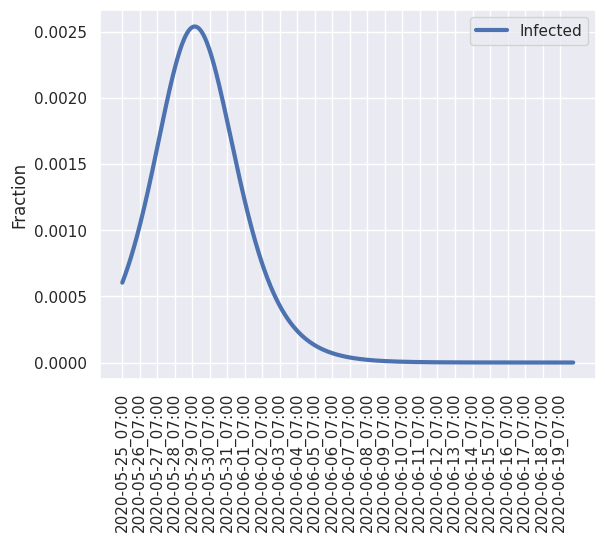

In [53]:
# Reconstruct Time Series
plt.plot(xdata, i, lw=3, label="Infected")
plt.grid(True)
plt.legend()
plt.ylabel("Fraction")
plt.xticks(xdata[::tick_interval], x_ticks[offset::tick_interval], rotation=90);
#plt.yscale("log")
plt.savefig("infected_timeline_sir.pdf", bbox_inches='tight')

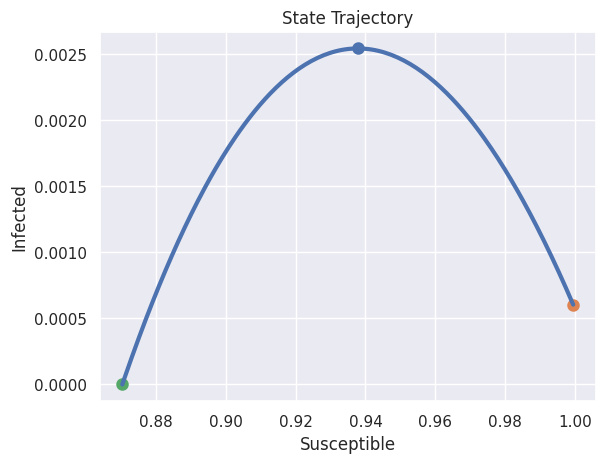

In [54]:
# Bifurcation Plot
R0 = beta/gamma

plt.plot(s, i, lw=3)
plt.scatter(1/R0, max(i), lw=3)
plt.scatter(s[0], i[0], lw=3)
plt.scatter(s[-1], i[-1], lw=3)

plt.xlabel("Susceptible")
plt.ylabel("Infected")
plt.grid(True)
plt.title("State Trajectory")
plt.savefig("state_trajectory_sir.pdf", bbox_inches='tight')

In [19]:
# True Number of Infected Users
timeline_infected_cumulative[-1] / timeline_total_users[-1]

0.12061471551506954

In [81]:
s[-1]

0.8704618072571072

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app


[0.00945972 0.00038403 0.00193462]


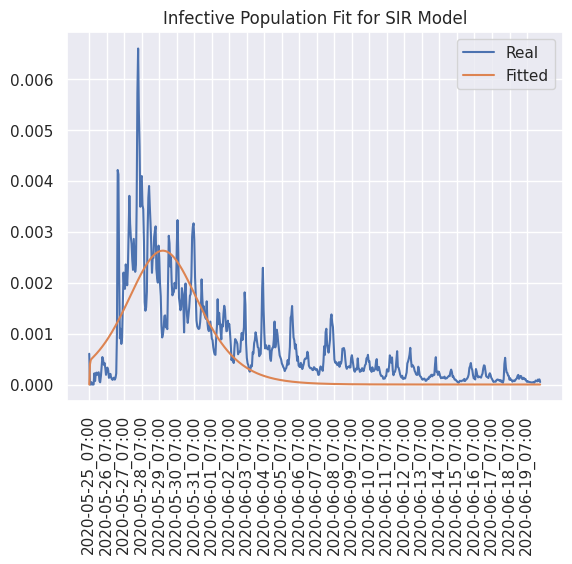

In [82]:
## SEIR Model

# shift time series
offset = np.where(np.asarray(timeline_infected) > 0)[0][0]

ydata = np.asarray(timeline_infected[offset:]) / timeline_total_users[offset:]

xdata = range(len(ydata))

def seir_model(y, xdata, alpha, beta, gamma):
    s, e, i, r = y
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

def fit_odeint(x, alpha, beta, gamma):
    return odeint(seir_model, (S0, E0, I0, R0), xdata, args=(alpha, beta, gamma))[:,1]

N = 1.0
I0 = ydata[0]
E0 = 0
S0 = N - I0 - E0
R0 = 0.0

popt, pcov = curve_fit(fit_odeint, xdata, ydata)
print(np.sqrt(np.diag(pcov)))  # standard deviation of errors on all parameters
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, label="Real")
plt.plot(xdata, fitted, label="Fitted")
plt.legend()
plt.title("Infective Population Fit for SIR Model")
plt.xticks(xdata[::tick_interval], x_ticks[offset::tick_interval], rotation=90);
plt.savefig("infective_population_fit_seir.pdf", bbox_inches='tight')

In [83]:
popt

array([0.46148761, 1.3706107 , 1.26532253])

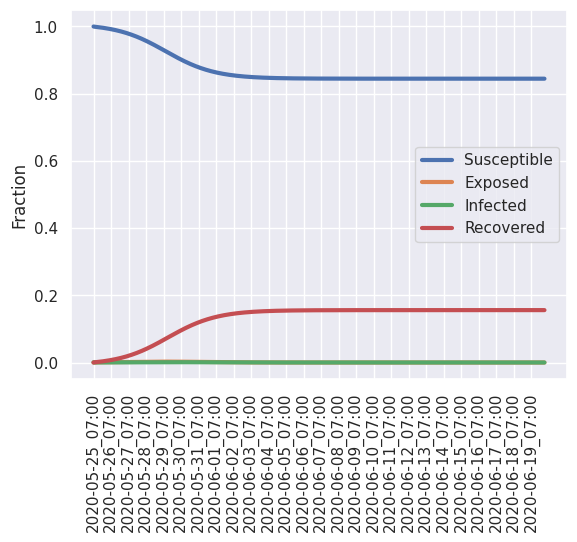

In [84]:
# Reconstruct Time Series
integral = odeint(seir_model, (S0, E0, I0, R0), xdata, args=(*popt,))
s, e, i, r = integral.T

plt.plot(xdata, s, lw=3, label="Susceptible")
plt.plot(xdata, e, lw=3, label="Exposed")
plt.plot(xdata, i, lw=3, label="Infected")
plt.plot(xdata, r, lw=3, label="Recovered")
plt.grid(True)
plt.legend()
#plt.xlabel("Time [in days]")
plt.ylabel("Fraction")
plt.xticks(xdata[::tick_interval], x_ticks[offset::tick_interval], rotation=90);
#plt.yscale("log")
plt.savefig("seir_timeline.pdf", bbox_inches='tight')

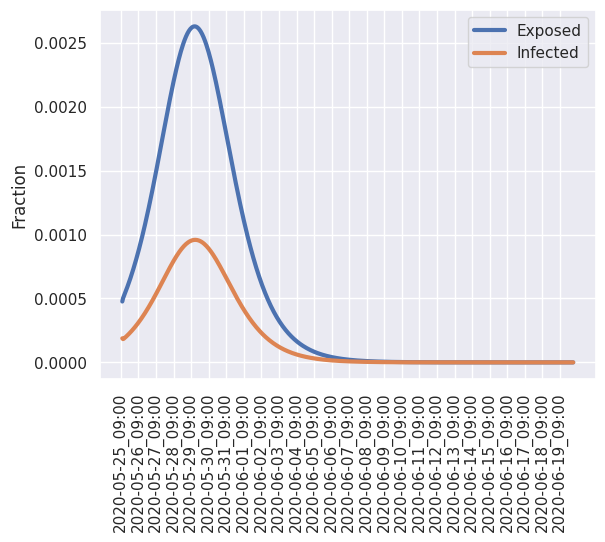

In [85]:
# Reconstruct Time Series
plt.plot(xdata[2:], e[2:], lw=3, label="Exposed")
plt.plot(xdata[2:], i[2:], lw=3, label="Infected")
plt.grid(True)
plt.legend()
plt.ylabel("Fraction")
plt.xticks(xdata[::tick_interval], x_ticks[offset+2::tick_interval], rotation=90);
#plt.yscale("log")
plt.savefig("infected_timeline_seir.pdf", bbox_inches='tight')

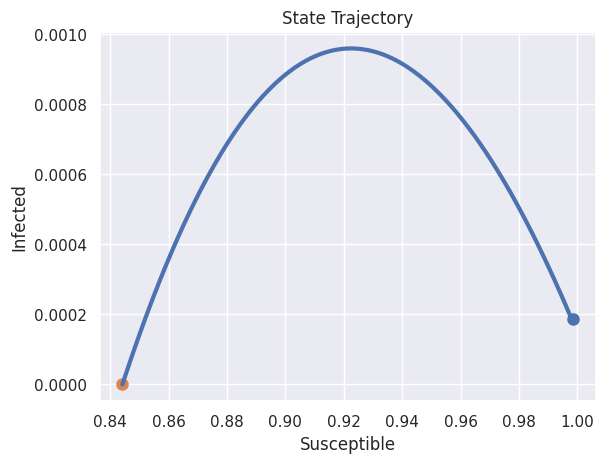

In [86]:
# Bifurcation Plot
R0 = beta/gamma

plt.plot(s[2:], i[2:], lw=3, label="S/I Trajectory")
#plt.plot([1/R0, 1/R0], [0, .001], '--', lw=3, label='di/dt = 0')
#plt.plot(s, e, lw=3, label="S/E Trajectory")
#plt.scatter(1/R0, max(i), lw=3)
plt.scatter(s[2], i[2], lw=3)
plt.scatter(s[-1], i[-1], lw=3)

plt.xlabel("Susceptible")
plt.ylabel("Infected")
plt.grid(True)
#plt.legend()
plt.title("State Trajectory")
plt.savefig("state_trajectory-seir.pdf", bbox_inches='tight')

In [87]:
s[-1]

0.8441776455756357